# Predicción de enfermedades de corazón

Disponemos de un dato que clasifica si los pacientes padecen cardiopatía o no según sus características. Intentaremos utilizar estos datos para crear un modelo que intente predecir si un paciente tiene esta enfermedad o no, utilizando el algoritmo de árboles de decisión.

La cardiopatía es un tipo de enfermedad que afecta el corazón o los vasos sanguíneos .El riesgo de ciertas cardiopatías aumenta por el consumo de productos del tabaco, la presión arterial alta, el colesterol alto, una alimentación poco saludable, la falta de ejercicio y la obesidad. La cardiopatía más común es la cardiopatía coronaria (arterias coronarias estrechas u obstruidas), que a veces produce dolor de pecho, infarto de miocardio o accidente cerebrovascular.

In [1]:
#importamos todas las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ggplot import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split

In [2]:
#importamos el dataset
data = pd.read_csv("../datasets/heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Los datos contienen:

* **age**: edad en años
* **sex**: (1 = hombre; 0 = mujer)
* **cp**: tipo de dolor en el pecho
* **trestbps**: presión arterial en reposo (en mm Hg al ingreso al hospital)
* **chol**: colestoral sérica en mg / dl
* **fbs**: (azúcar en sangre en ayunas> 120 mg / dl) (1 = verdadero; 0 = falso)
* **restecg**: resultados electrocardiográficos en reposo
* **thalach**: frecuencia cardíaca máxima alcanzada
* **exang**: angina inducida por ejercicio (1 = sí; 0 = no)
* **oldpeak**: Depresión del ST inducida por el ejercicio en relación con el reposo
* **slope**: la pendiente del segmento ST de ejercicio pico
* **ca**: número de vasos principales (0-3) coloreados por la floración
* **thal**: 3 = normal; 6 = defecto fijo; 7 = defecto reversible
* **target**: tiene enfermedad o no (1 = sí, 0 = no)

## 1. Análisis exploratorio

A continuacion hacemos un análisis exploratorio de los datos para entender mejor cómo están compuestos y prepararlos para el modelo.

In [3]:
#dimensión del dataset
data.shape

(303, 14)

Vemos que el dataset está compuesto de 303 filas y 14 columnas

In [4]:
#función para imprimir resumen de los datos
def getMetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Tipo' : dataframe.dtypes, # tipo de datos
                    'Elementos': dataframe.count(), # cantidad de elementos en la columna
                    'Nulos': dataframe.isnull().sum(), # cantidad de nulos
                    'Nulos %': round(dataframe.isnull().sum()/len(dataframe) * 100,2) , #porcentaje de nulos
                    'Valores unicos': dataframe.nunique() #cantidad de valores unicos
                       })
    return metadata_matrix

In [5]:
getMetadata(data)

,Tipo,Elementos,Nulos,Nulos %,Valores unicos
age,int64,303,0,0.0,41
sex,int64,303,0,0.0,2
cp,int64,303,0,0.0,4
trestbps,int64,303,0,0.0,49
chol,int64,303,0,0.0,152
fbs,int64,303,0,0.0,2
restecg,int64,303,0,0.0,3
thalach,int64,303,0,0.0,91
exang,int64,303,0,0.0,2
oldpeak,float64,303,0,0.0,40


Aquí vemos que no hay valores nulos en ninguna columna y todas las variables son de tipo numerico. Si consideramos que hay muchas variables que tienen pocos valores unicos, esto significa que en realidad son categóricas y debemos tratarlas como tales.

In [6]:
#generamos una lista de las variables categoricas
cat = ["sex","cp","fbs","restecg","exang","slope","ca","thal","target"]


#pasamos todas a tipo categoría
for col in data[cat]:
    data[col] = data[col].astype("category")

In [7]:
#validamos los cambios
getMetadata(data)

,Tipo,Elementos,Nulos,Nulos %,Valores unicos
age,int64,303,0,0.0,41
sex,category,303,0,0.0,2
cp,category,303,0,0.0,4
trestbps,int64,303,0,0.0,49
chol,int64,303,0,0.0,152
fbs,category,303,0,0.0,2
restecg,category,303,0,0.0,3
thalach,int64,303,0,0.0,91
exang,category,303,0,0.0,2
oldpeak,float64,303,0,0.0,40


In [8]:
# vemos un resumen estadístico de las variables numericas
data.describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


Aquí tenemos una primera paroximación a la distribución de los datos:

* La variable **edad**, como es lógico, tiende a tener una distribución normal con media (54.36 años ) y mediana (55 años) iguales. La edad minima es de 29 años, lo cual puede atribuirse a que los más jovenes no se someten a estudios cardiológicos. El 75% de las personas tienen entre 47 y 77 años.
* Del resto de las variables, vemos que oldpeack está muy concentrada en sus valores máximos y las restantes tienen valores más distribuidos.

In [9]:
#vemos ahora el resumen de las variables categíricas
data.describe(include="category")

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


* En la variable **sexo** vemos 207 personas son hombres, lo que representa un 68% del total. 
* La mayoría no tiene exceso de azucar en la sangre (variable **fbps**)
* El tipo 4 de **dolor en el pecho** es el que mas prevalece

A continuación se realiza un análisis individual de algunas de las variables del dataset y su relación con la enfermedad.

### Variable target

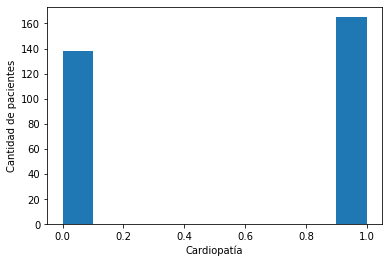

In [10]:
%matplotlib inline
plt.hist(data.target)
plt.xlabel("Cardiopatía")
plt.ylabel("Cantidad de pacientes")
plt.show()

Vemos que, de los pacientes que se someten a estudios, son más los que se diagnostican con cardiopatía que los que no.

### Variable edad

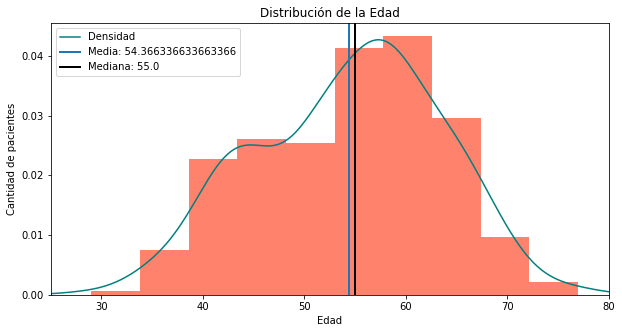

In [11]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.xlim([25,80])
plt.hist(x=data["age"],density=True,color="tomato",alpha =0.8)
data["age"].plot(kind='density', color='teal',label="Densidad")
plt.axvline(x=data["age"].mean(),ymin=0,ymax=50,linewidth=2,label="Media: {}".format(data["age"].mean()))
plt.axvline(x=data["age"].median(),ymin=0,ymax=50,color="black",linewidth=2,label="Mediana: {}".format(data["age"].median()))
plt.title("Distribución de la Edad")
plt.xlabel("Edad")
plt.ylabel("Cantidad de pacientes")
plt.legend()
plt.show()

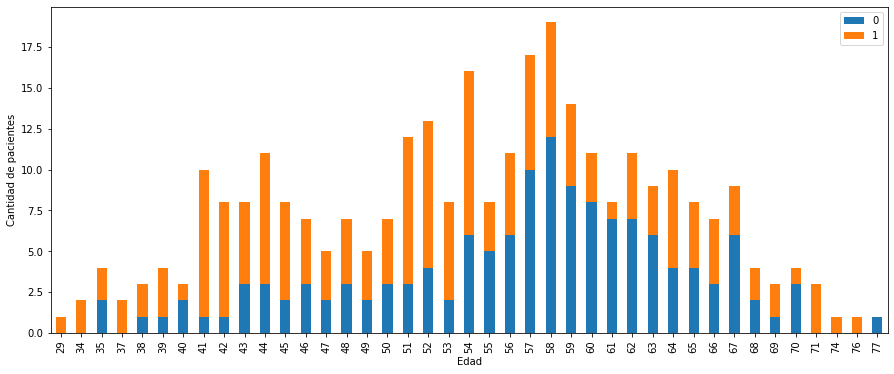

In [12]:
%matplotlib inline
pd.crosstab(data.age, data.target).plot(kind="bar",figsize=(15,6),stacked=True)
plt.xlabel("Edad")
plt.ylabel("Cantidad de pacientes")
plt.legend()
plt.show()

Relacionando la edad con la enfermedad, vemos que entre los 41 y los 54 años es donde los pacientes con la enfermedad superan a los que no la tienen. También podemos ver que las edades donde más se someten a estudios son 57 y 58 años. 

### Variable colesterol

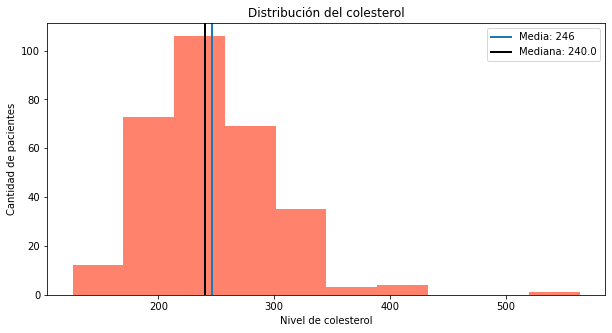

In [13]:
%matplotlib inline
plt.figure(figsize=(10,5))
#plt.xlim([25,80])
plt.hist(x=data["chol"],color="tomato",alpha =0.8)
plt.axvline(x=data["chol"].mean(),ymin=0,ymax=50,linewidth=2,label="Media: {}".format(round(data["chol"].mean()),2))
plt.axvline(x=data["chol"].median(),ymin=0,ymax=50,color="black",linewidth=2,label="Mediana: {}".format(data["chol"].median()))
plt.title("Distribución del colesterol")
plt.xlabel("Nivel de colesterol")
plt.ylabel("Cantidad de pacientes")
plt.legend()
plt.show()

El nivel de colesterol sigue una distibución que se aproxima a la normal, con la mayoría de los pacientes en rangos medios. Vemos que hay un outlier con rango mayor a 500. Dado que los outliers no suelen afectar los algoritmos de arboles de decisión, no se elimina este valor.

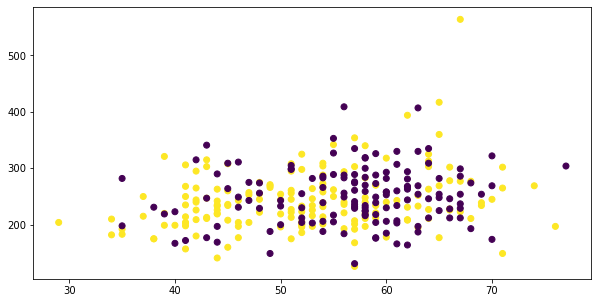

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(x=data["age"],y=data["chol"],c=data["target"])

Si relacionamos la edad con el nivel de colseterol, no parece seguir una relacion lineal. Solo se vislumbra una tendencia a pacientes con diagnostico positivo a mayor edad.

### Variable azucar en sangre

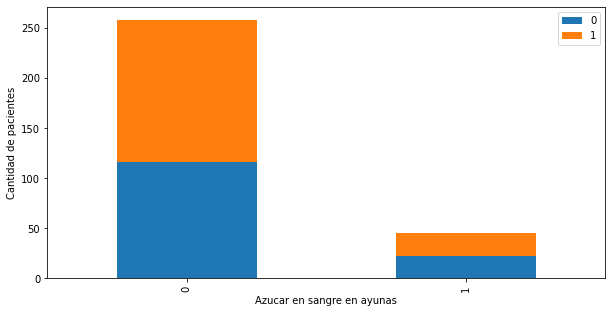

In [15]:
%matplotlib inline
pd.crosstab(data.fbs, data.target).plot(kind="bar",figsize=(10,5),stacked=True)
plt.xlabel("Azucar en sangre en ayunas")
plt.ylabel("Cantidad de pacientes")
plt.legend()
plt.show()

Esta variable no parece influir sobre la cardiopatía, ya que tanto los que tienen azucar en sangre como los que no, tienen porcentajes similares de casos positivos.

### Variable sexo

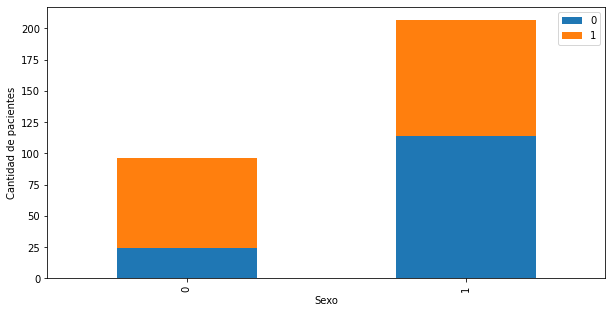

In [16]:
%matplotlib inline
pd.crosstab(data.sex, data.target).plot(kind="bar",figsize=(10,5),stacked=True)
plt.xlabel("Sexo")
plt.ylabel("Cantidad de pacientes")
plt.legend()
plt.show()

Aquí vemos que en el caso de las mujeres es mucho mayor la proporción de casos positivos que en el caso de los hombres.

## 2. Modelo de clasificación

Luego de haber realizado un breve análisis de los datos, procedemos a aplicar el algoritmo para clasificarlos pacientes.

In [17]:
#generamos las variables predictoras y target
colnames = data.columns.values.tolist() #lista con todas las columnas
pred = colnames[:-1] #variables predictoras
target = colnames[-1] #variable a predecir

In [18]:
# separamos el dataset en datos de train y test
train, test = train_test_split(data, test_size = 20)

In [19]:
#generamos el modelo y lo entrenamos con os datos de entrenamiento
tree = DecisionTreeClassifier(criterion="entropy", min_samples_split=20, random_state=99)
tree.fit(train[pred], train[target])

DecisionTreeClassifier(criterion='entropy', min_samples_split=20,
                       random_state=99)

In [20]:
#predecimos la categoría de cada observación con los datos de test
preds = tree.predict(test[pred])

In [21]:
#comparamos en una matriz las predicciones vs los valores reales
pd.crosstab(test[target], preds, rownames=["Real"], colnames=["Predicciones"])

Predicciones,0,1
Real,,
0,6,1
1,3,10


In [22]:
#generamos un archivo .dot con la informacion del arbol
with open("heart.dot", "w") as dotfile:
    export_graphviz(tree, out_file=dotfile, feature_names=pred)
    dotfile.close()

In [23]:
#leemos el archivo creado
file = open("heart.dot", "r")
text = file.read()

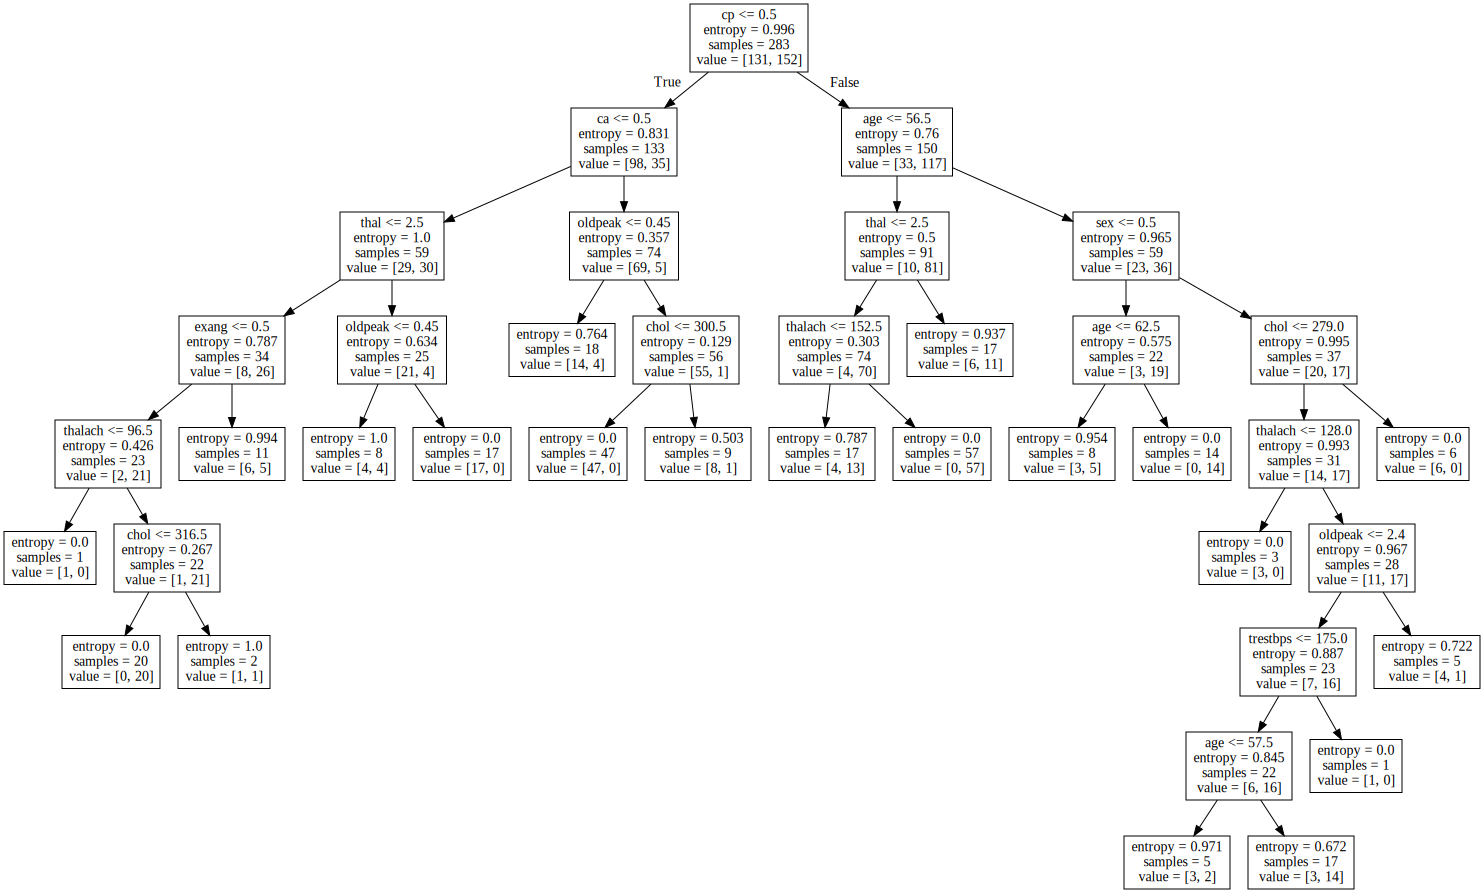

In [24]:
Source(text)

Vemos que el algoritmo arroja de manera automatica una profundidad de 5 niveles de decisión para el arbol.

## 3. Validación cruzada

In [25]:
#generamos las X e Y con todos los datos del dataset
X = data[pred]
Y = data[target]

In [26]:
#generamos el modelo con un nivel de profundidad maximo de 5
tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=20, random_state=99)
tree.fit(X,Y)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=20,
                       random_state=99)

In [27]:
#validación cruzada separando en 10 grupos
cv = KFold(n_splits=10, shuffle=True, random_state=1)
cv.get_n_splits(X)


10

In [28]:
#obtenemos los scores de cada iteración de la validación cruzada
scores = cross_val_score(tree, X, Y, scoring="accuracy", cv = cv, n_jobs=1)
scores

array([0.87096774, 0.61290323, 0.77419355, 0.76666667, 0.73333333,
       0.83333333, 0.7       , 0.9       , 0.93333333, 0.66666667])

In [29]:
#obtenemos el score promedio de la validación
score = np.mean(scores)
score

0.7791397849462366

El score del arbol con una profundidad de 5 niveles es de 77,9%. Para validar si es el nivel indicado, generamos un score para cada nivel de profundidad entre 1 y 10 y lo comparamos.

In [30]:
#hacemos un bucle para ver el score con niveles de profundidad entre 1 y 10
for i in range(1,11):
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=i, min_samples_split=20, random_state=99)
    tree.fit(X,Y)
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    cv.get_n_splits(X)
    scores = cross_val_score(tree, X, Y, scoring="accuracy", cv = cv, n_jobs=-1)
    score = np.mean(scores)
    print("Score para i = ",i," es de ", np.round(score,4)*100)
    print("   ",tree.feature_importances_)

Score para i =  1  es de  74.29
    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Score para i =  2  es de  74.59
    [0.12689719 0.         0.59045513 0.         0.         0.
 0.         0.         0.         0.         0.         0.28264767
 0.        ]
Score para i =  3  es de  77.58
    [0.09295622 0.06354305 0.43252712 0.         0.         0.
 0.         0.         0.         0.0381194  0.         0.20704839
 0.16580583]
Score para i =  4  es de  75.92
    [0.103102   0.0498852  0.33956041 0.         0.0517285  0.
 0.         0.05098501 0.03384978 0.07817559 0.         0.16254573
 0.13016778]
Score para i =  5  es de  77.91
    [0.09731562 0.0470855  0.32050331 0.         0.04882535 0.
 0.         0.06913241 0.03195003 0.10890218 0.         0.1534232
 0.12286239]
Score para i =  6  es de  77.91
    [0.09376999 0.04536997 0.30882596 0.         0.06697204 0.
 0.         0.06661361 0.03078595 0.10493439 0.         0.16434212
 0.11838597]
Score para i =  7  es de  77.91
    [0.09376999 0

Vemos que el mejor score se alcanza para una profundidad de 8 niveles con un score de 78.25% y no aumenta en los niveles siguientes. Si consideramos que el algoritmo arrojaba un nivel de profundidad de 5 con un score de 77.91%, es la profundidad ideal ya que la diferencia con 8 niveles en cuanto al score es minima y tener menos profundidad simplifica el arbo.

## Random Forest

A continuación aplicaremos el algoritmo de Random Forest para clasificación y veremos si mejora la puntuación de las predicciones.

In [31]:
#importamos la librería
from sklearn.ensemble import RandomForestClassifier

In [32]:
#generamos el modelo con 100 arboles
forest = RandomForestClassifier(n_jobs=2, oob_score=True, n_estimators=100)

In [33]:
#entrenamos el modelo con todo el dataset. No es necesario dividir los datos en train y test en este algoritmo.
forest.fit(X,Y)

RandomForestClassifier(n_jobs=2, oob_score=True)

In [34]:
#mostramos todas las predicciones de las probabilidades de cada observacion
forest.oob_decision_function_

array([[0.41666667, 0.58333333],
       [0.44444444, 0.55555556],
       [0.03125   , 0.96875   ],
       [0.11111111, 0.88888889],
       [0.24137931, 0.75862069],
       [0.23076923, 0.76923077],
       [0.0625    , 0.9375    ],
       [0.26666667, 0.73333333],
       [0.13953488, 0.86046512],
       [0.15      , 0.85      ],
       [0.14285714, 0.85714286],
       [0.26315789, 0.73684211],
       [0.02083333, 0.97916667],
       [0.44827586, 0.55172414],
       [0.15      , 0.85      ],
       [0.03030303, 0.96969697],
       [0.11904762, 0.88095238],
       [0.46666667, 0.53333333],
       [0.13793103, 0.86206897],
       [0.51851852, 0.48148148],
       [0.76190476, 0.23809524],
       [0.0625    , 0.9375    ],
       [0.14893617, 0.85106383],
       [0.60465116, 0.39534884],
       [0.45833333, 0.54166667],
       [0.19444444, 0.80555556],
       [0.14285714, 0.85714286],
       [0.31578947, 0.68421053],
       [0.2972973 , 0.7027027 ],
       [0.11764706, 0.88235294],
       [0.

In [35]:
#obtenemos el score
forest.oob_score_

0.8151815181518152

Vemos que, generando un bosque de 100 árboles, el score aumenta más de un 3%.

In [42]:
#probamos con mil árboles
forest = RandomForestClassifier(n_jobs=2, oob_score=True, n_estimators=1000)
forest.fit(X,Y)
forest.oob_score_

0.8250825082508251

El score aumenta 